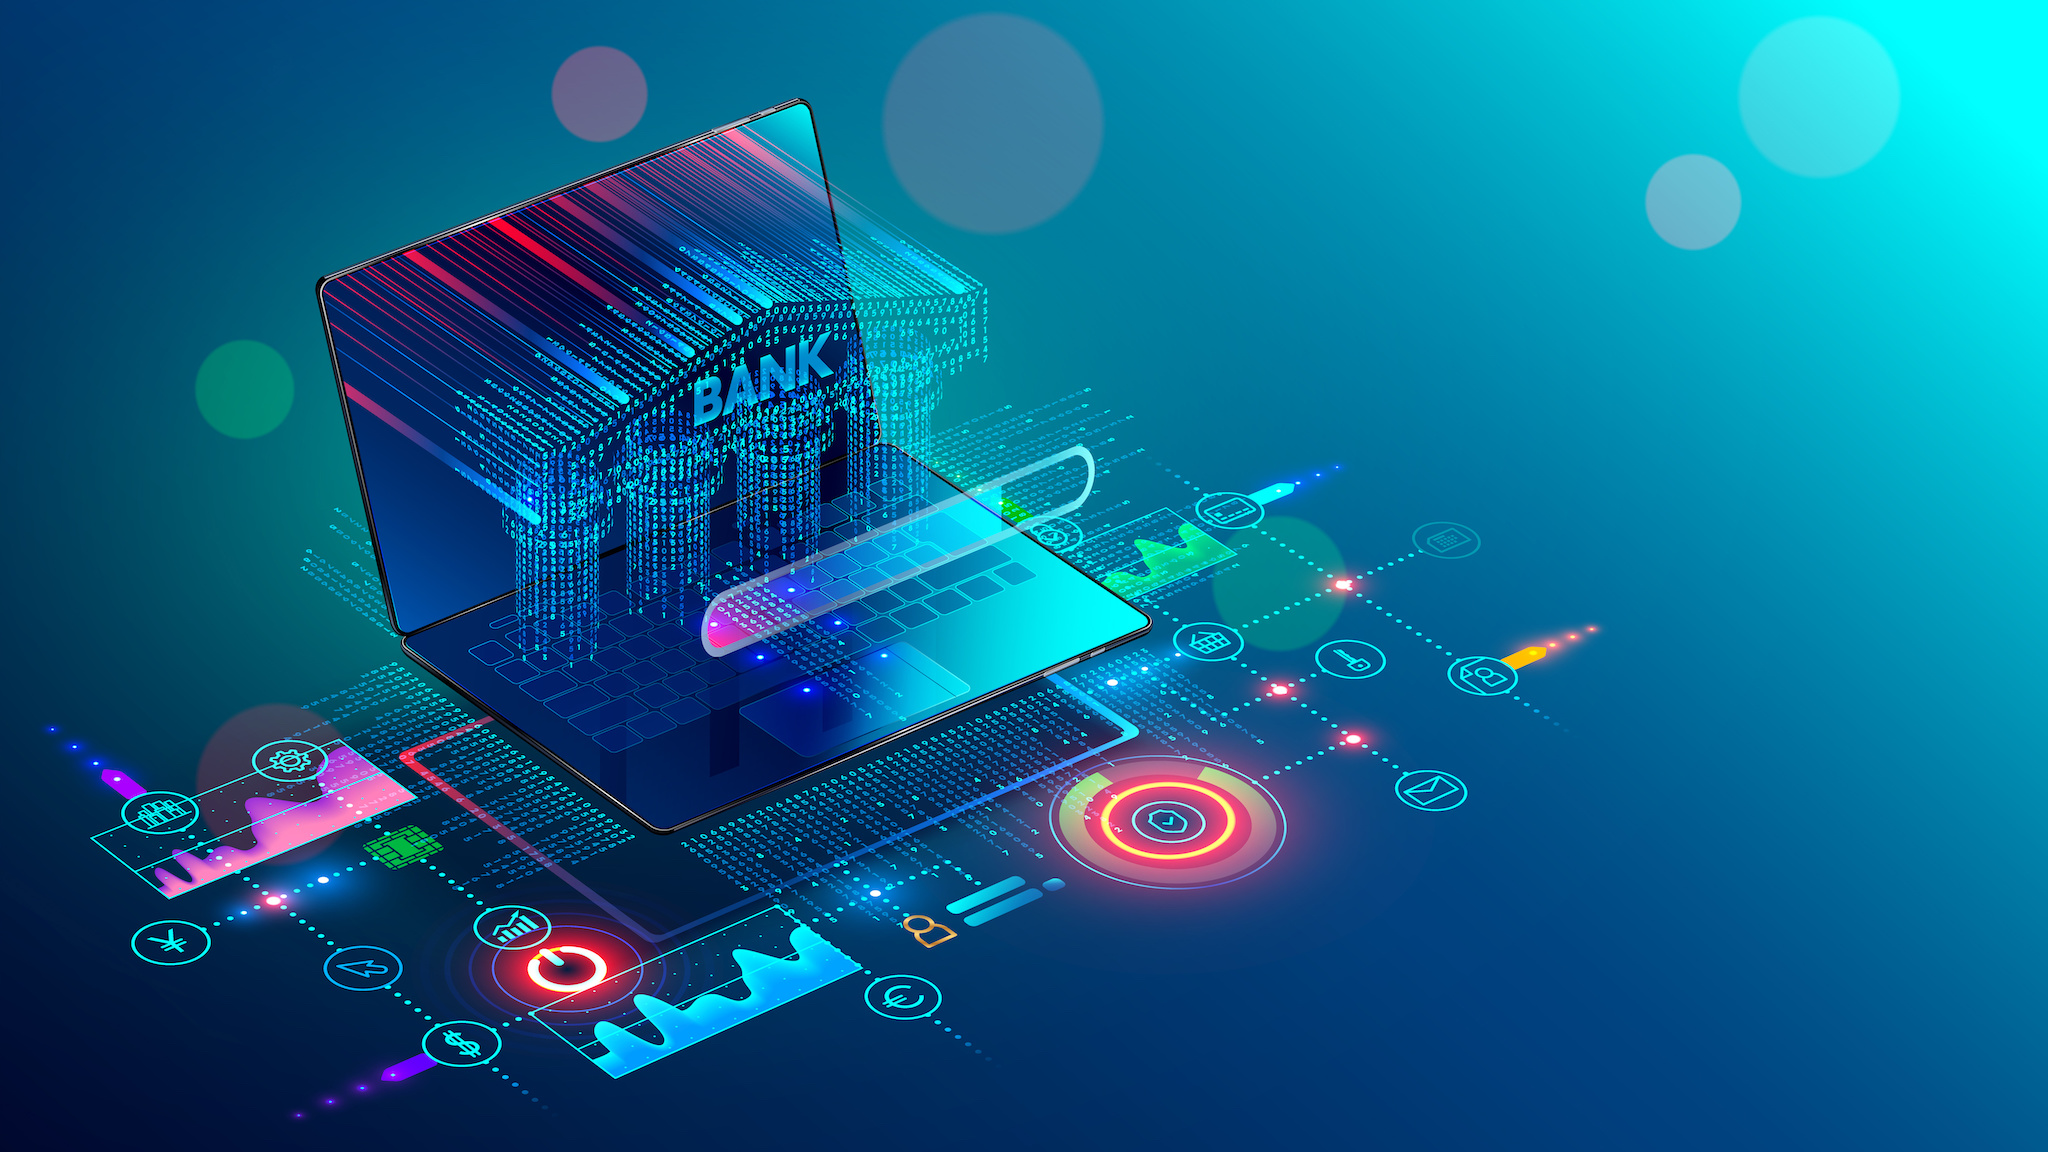
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 1: Intro, EDA and Preprocessing

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

## Goal: 

*This is a project for learning purposes. The *** is not involved with this project in any way.*

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Initial Exploratory Data Analysis

### Google colab compatibility downloads

In [ ]:
# !sudo apt update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
# !tar xf spark-3.0.0-bin-hadoop3.2.tgz
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
# !pip install pyspark==3
# !pip install -q findspark
# import findspark
# findspark.init()

### Import libraries, packages and modules

In [ ]:
import numpy as np
import pandas as pd
import os

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, TimestampType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
from IPython.display import HTML, display
%matplotlib inline

In [ ]:
# # Check colab GPU info

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Not connected to a GPU')
# else:
#     print(gpu_info)

In [ ]:
# # Set text to wrap in Google colab notebook

# def set_css():
#     display(HTML('''
#     <style>
#     pre {
#         white-space: pre-wrap;
#     }
#     </style>
#     '''))
# get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# # Initialize Spark Session

spark = SparkSession.builder.master('local[*]').getOrCreate()
# spark = SparkSession.builder\
#         .master("local[*]")\
#         .appName("Colab")\
#         .config('spark.ui.port', '4050')\
#         .getOrCreate()

### Description of Features

**Dataset 1 – Transactions:**

`MessageId` - Globally unique identifier within this dataset for individual transactions<br>
`UETR` - The Unique End-to-end Transaction Reference—a 36-character string enabling traceability of all individual transactions associated with a single end-to-end transaction<br>
`TransactionReference` - Unique identifier for an individual transaction<br>
`Timestamp` - Time at which the individual transaction was initiated<br>
`Sender` - Institution (bank) initiating/sending the individual transaction<br>
`Receiver` - Institution (bank) receiving the individual transaction<br>
`OrderingAccount` - Account identifier for the originating ordering entity (individual or organization) for end-to-end transaction<br>
`OrderingName` - Name for the originating ordering entity<br>
`OrderingStreet` - Street address for the originating ordering entity<br>
`OrderingCountryCityZip` - Remaining address details for the originating ordering entity<br>
`BeneficiaryAccount` - Account identifier for the final beneficiary entity (individual or organization) for end-to-end transaction<br>
`BeneficiaryName` - Name for the final beneficiary entity<br>
`BeneficiaryStreet` - Street address for the final beneficiary entity<br>
`BeneficiaryCountryCityZip` - Remaining address details for the final beneficiary entity<br>
`SettlementDate` - Date the individual transaction was settled<br>
`SettlementCurrency` - Currency used for transaction<br>
`SettlementAmount` - Value of the transaction net of fees/transfer charges/forex<br>
`InstructedCurrency` - Currency of the individual transaction as instructed to be paid by the Sender<br>
`InstructedAmount` - Value of the individual transaction as instructed to be paid by the Sender<br>
`Label` - Boolean indicator of whether the transaction is anomalous or not. This is the target variable for the prediction task.<br>

**Dataset 2 – Banks:**

`Bank` - Identifier for the bank<br>
`Account` - Identifier for the account<br>
`Name` - Name of the account<br>
`Street` - Street address associated with the account<br>
`CountryCityZip` - Remaining address details associated with the account<br>
`Flags` - Enumerated data type indicating potential issues or special features that have been associated with an account. Flag definitions are below:<br>
00 - No flags<br>
01 - Account closed<br>
03 - Account recently opened<br>
04 - Name mismatch<br>
05 - Account under monitoring<br>
06 - Account suspended<br>
07 - Account frozen<br>
08 - Non-transaction account<br>
09 - Beneficiary deceased<br>
10 - Invalid company ID<br>
11 - Invalid individual ID<br>

### Read in Data

In [ ]:
# Read in transactions data csv file to a Spark DataFrame
transactions_df = spark.read.csv('data/transaction_train_dataset.csv', header=True, inferSchema=True)

# Read in banks data csv file to a Spark DataFrame
banks_df = spark.read.csv('data/bank_dataset.csv', header=True, inferSchema=True)

### Initial EDA

In [ ]:
# Print shape of dataframes
print(f"transactions_df:  {transactions_df.count():,} Rows, {len(transactions_df.columns)} Columns")
print(f"banks_df:  {banks_df.count():,} Rows, {len(banks_df.columns)} Columns")

In [ ]:
transactions_df.printSchema()

In [ ]:
banks_df.printSchema()

In [ ]:
# Print first row of transactions dataframe
transactions_df.show(n=2, vertical=True, truncate=False)

In [ ]:
# Print first row of banks dataframe
banks_df.show(n=5, truncate=False)

In [ ]:
# Print number of null/missing values in each column of transactions_df
transactions_df_null = transactions_df.select([F.count(F.when(F.col(c).contains('None') | \
                                                              F.col(c).contains('NULL') | \
                                                              (F.col(c) == '' ) | \
                                                              F.col(c).isNull() | \
                                                              F.isnan(c), c ))\
                                               .alias(c) for c in transactions_df.columns])

print('Number of null/missing values per column:\n')
transactions_df_null.show(vertical=True, truncate=False)

In [ ]:
# Print number of null/missing values in each column of banks_df
banks_df_null = banks_df.select([F.count(F.when(F.col(c).contains('None') | \
                                                F.col(c).contains('NULL') | \
                                                (F.col(c) == '' ) | \
                                                F.col(c).isNull() | \
                                                F.isnan(c), c ))\
                                 .alias(c) for c in banks_df.columns])

print('Number of null/missing values per column:\n')
banks_df_null.show(vertical=True, truncate=False)

In [ ]:
# Print number of unique values in each column in transactions_df; sample 10% of df for efficiency
transactions_df_unique = transactions_df.sample(False, 0.1).agg(*(F.countDistinct(F.col(c)) for c in transactions_df.columns))

print(f"Number of unique values per column (in sample of 10% of dataframe):\n")
transactions_df_unique.show(vertical=True, truncate=False)

In [ ]:
# Print number of unique values in each column in banks_df; sample 10% of df for efficiency
banks_df_unique = banks_df.sample(False, 0.1).agg(*(F.countDistinct(F.col(c)) for c in banks_df.columns))

print(f"Number of unique values per column (in sample of 10% of dataframe):\n")
banks_df_unique.show(vertical=True, truncate=False)

In [ ]:
# Show value counts for 'Label' column (classification target) in transactions_df
class_counts = transactions_df.groupBy('Label').count().withColumn('percent', F.col('count')/transactions_df.count())

class_counts.show(truncate=10)

**Remarks:**
- It looks like this is an extremely imbalanced dataset - only about 0.1% of the data is in the positive class. We will need to address this class imbalance as part of the modeling process.

# Preprocessing

Steps:
1. Join dataframes
2. Change column datatypes to correct type

In [ ]:
# Specify join condition
join_condition = (transactions_df.OrderingAccount == banks_df.Account) | (transactions_df.BeneficiaryAccount == banks_df.Account)

# Join dataframes
preprocessed_df = transactions_df.join(banks_df, on=join_condition, how='left')

# Unpersist old dataframes from memory
display(transactions_df.unpersist())
banks_df.unpersist()

In [ ]:
# Print shape of joined dataframe
print(f"{transactions_df.count():,} Rows, {len(transactions_df.columns)} Columns")

In [ ]:
# Convert 'Timestamp' column to TimestampType
transactions_df = transactions_df.withColumn('Timestamp', transactions_df.Timestamp.cast(TimestampType()))

assert transactions_df.select('Timestamp').dtypes[0][0] == 'Timestamp'